In [68]:
from collections import OrderedDict

import numpy as np
from PIL import Image
import matplotlib.image as img
import matplotlib.pyplot as plt

from dataset.mnist import load_mnist
from function.layer import *


In [17]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size,
        weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
            np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * \
            np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = \
            Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = \
            Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1:
            t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

    def gradient(self, x, t):
        # 순전파
        self.loss(x, t)

        # 역전파
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db

        return grads


In [18]:
# 정확도 검증
(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

# 각 가중치의 차이의 절댓값을 구한 후, 그 절댓값들의 평균을 낸다.
for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ":" + str(diff))

W1:2.216696723630171e-13
b1:6.832173585560874e-13
W2:8.136243804748476e-13
b2:1.205702135353981e-10


In [19]:
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼 파라메터
iters_num = 10000  # 반복횟수
train_size = x_train.shape[0]
batch_size = 100  # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # print(i)
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 오차역전파법으로 기울기 계산
    grad = network.gradient(x_batch, t_batch)

    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    # 1에폭 당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))


train acc, test acc | 0.11003333333333333, 0.1157
train acc, test acc | 0.9059833333333334, 0.9095
train acc, test acc | 0.9263333333333333, 0.9297
train acc, test acc | 0.9398, 0.9388
train acc, test acc | 0.9456, 0.9445
train acc, test acc | 0.95305, 0.9506
train acc, test acc | 0.95855, 0.9559
train acc, test acc | 0.9613333333333334, 0.9571
train acc, test acc | 0.9655166666666667, 0.9599
train acc, test acc | 0.9678, 0.962
train acc, test acc | 0.97025, 0.9621
train acc, test acc | 0.9729166666666667, 0.9639
train acc, test acc | 0.9748, 0.9655
train acc, test acc | 0.9739166666666667, 0.9661
train acc, test acc | 0.9766166666666667, 0.9676
train acc, test acc | 0.9784333333333334, 0.9672
train acc, test acc | 0.9793333333333333, 0.9689


In [54]:
a = network.predict(np.array(Image.open("./dataset/test.png",).convert('L'), 'uint8').flatten().reshape((1, 784)))
print(np.argmax(a))
print(a)

9
[[ -691.10526003  -152.64418021 -1010.50418955    10.98069209
    405.45355296   139.73572846  -869.94122695   334.52955596
    637.9572439   1178.55329027]]


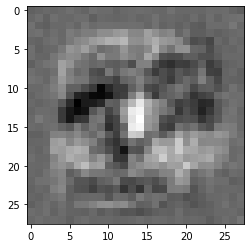

In [81]:
_norr = lambda T: (((T-T.min()) / (T.max() - T.min()))*255).astype('uint8').reshape(28, 28)
plt.imshow(_norr(network.params["W1"][:,19]), cmap='gray')
plt.show()
